In [93]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sbn # For nice looking plots.

import numpy as np
import scipy as sp
import scipy.io

import os
import copy
import time
import datetime

import tensorflow as tf

import sklearn
import sklearn.ensemble
import sklearn.preprocessing

np.set_printoptions(precision=2, suppress=True, linewidth=140)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
# Load the training and test data
sarcos_inv = scipy.io.loadmat('../data/sarcos_inv.mat')['sarcos_inv']
sarcos_inv_test = scipy.io.loadmat('../data/sarcos_inv_test.mat')['sarcos_inv_test']

def split_data(data, timesteps=1):
    X, Y = np.split(data, [21], axis=1)
    
    if timesteps == 1:
        return X, Y
    
    Xres = np.zeros((X.shape[0] - timesteps + 1, 21 * timesteps))
    Yres = Y[timesteps - 1:]
    
    for i in xrange(X.shape[0] - timesteps + 1):
        Xres[i] = np.reshape(X[i:i+timesteps], -1)
    
    return Xres, Yres


# Train random forest with different tree depth and n_estimators

In [123]:
# Training with different tree depth

params = []
for n_estimators in [5, 10, 15, 20]:
    for max_depth in [5, 10, 15, 20, 25, 30]:
        params.append({
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'n_jobs': 7
        })


nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

# Model orders to be tested
RSSts = np.zeros((len(params), nfold))

X0, y0 = split_data(sarcos_inv)

for isplit, Ind in enumerate(kf.split(X0)):
    print('kfold split: %d' % (isplit))
    
    Itr, Its = Ind
    xtr = X0[Itr]
    ytr = y0[Itr]
    xts = X0[Its]
    yts = y0[Its]
    
    for it, param in enumerate(params):
        model = sklearn.ensemble.RandomForestRegressor(**param)
        model.fit(xtr, ytr)
        
        yhat = model.predict(xts)
        
        RSSts[it, isplit] = np.mean((yts - yhat)**2)
    
print 'done'

kfold split: 0
kfold split: 1
kfold split: 2
kfold split: 3


KeyboardInterrupt: 

Min loss:
{'n_jobs': 7, 'l2_mean': 4.080810670575591, 'l2_std': 0.060247548267556926, 'l2_loss': 4.080810670575591, 'n_estimators': 20, 'max_depth': 30}

{'n_jobs': 7, 'l2_mean': 4.0942795474263916, 'l2_std': 0.026207673546073458, 'l2_loss': 4.0942795474263916, 'n_estimators': 20, 'max_depth': 20}
{'n_jobs': 7, 'l2_mean': 4.1002784563066745, 'l2_std': 0.028943763090936988, 'l2_loss': 4.1002784563066745, 'n_estimators': 20, 'max_depth': 25}
{'n_jobs': 7, 'l2_mean': 4.080810670575591, 'l2_std': 0.060247548267556926, 'l2_loss': 4.080810670575591, 'n_estimators': 20, 'max_depth': 30}


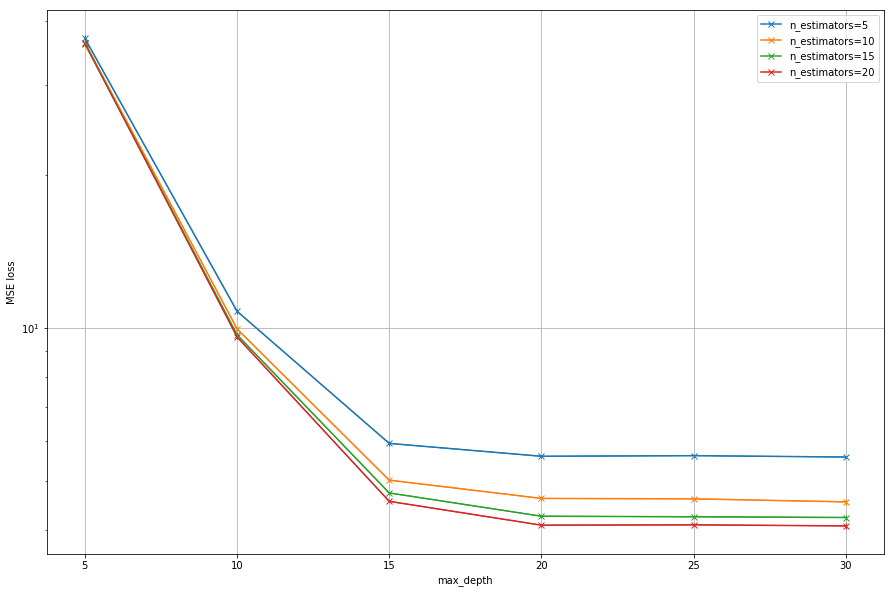

In [122]:
fig, axes = plt.subplots(1, 1, figsize=(15, 10))
# axes = np.array(axes).reshape(-1)

for i, p in enumerate(params):
    p['l2_mean'] = np.mean(RSSts, axis=1)[i]
    p['l2_std'] = np.std(RSSts, axis=1)[i] / np.sqrt(nfold - 1)

for i, n_estimators in enumerate(np.unique([p['n_estimators'] for p in params])):
    ax = axes
    
    pars = [p for p in params if p['n_estimators'] == n_estimators]
    x = [p['max_depth'] for p in pars]
    y = [p['l2_mean'] for p in pars]
    yerr = [p['l2_std'] for p in pars]
    
    ax.set_yscale("log", nonposy='clip')
    
    p = ax.plot(x, y, 'x-', label="n_estimators=%d" % (n_estimators))
    ax.errorbar(x, y ,yerr=yerr, linewidth=1, color=p[0].get_color())
    
plt.xlabel('max_depth')
plt.ylabel('MSE loss')
plt.grid()
plt.legend()


l2_mean = [p['l2_mean'] for p in params]
l2_std = [p['l2_std'] for p in params]
min_idx = np.argmin(l2_mean)

print 'Min loss:'
print params[min_idx]
print ''

param_stdrule = [p for p in params if p['l2_mean'] < params[min_idx]['l2_mean'] + params[min_idx]['l2_std']]
for p in param_stdrule:
    print p

# Train random forest over many history steps

In [ ]:
# Training with different tree depth

total_params = []

for history_steps in [1, 3]:
    params = []
    for n_estimators in [5, 10, 15, 20]:
        for max_depth in [5, 10, 15, 20, 25, 30]:
            params.append({
                'model': {
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'n_jobs': 7
                },
                'history_steps': history_steps
            })

    nfold = 10
    kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

    # Model orders to be tested
    RSSts = np.zeros((len(params), nfold))

    X0, y0 = split_data(sarcos_inv, history_steps)
    
    for isplit, Ind in enumerate(kf.split(X0)):
        print('kfold split: %d' % (isplit))

        Itr, Its = Ind

        xtr = X0[Itr]
        ytr = y0[Itr]
        xts = X0[Its]
        yts = y0[Its]

        for it, param in enumerate(params):
            model = sklearn.ensemble.RandomForestRegressor(**param['model'])
            model.fit(xtr, ytr)

            yhat = model.predict(xts)
            RSSts[it, isplit] = np.mean((yts - yhat)**2)

    # Compute the l2 mean and normalized std right here.
    for i, p in enumerate(params):
        p['l2_mean'] = np.mean(RSSts, axis=1)[i]
        p['l2_std'] = np.std(RSSts, axis=1)[i] / np.sqrt(nfold - 1)
        
    total_params += params
            
params = total_params

kfold split: 0
kfold split: 1
kfold split: 2
kfold split: 3
kfold split: 4
kfold split: 5
kfold split: 6
kfold split: 7
kfold split: 8
kfold split: 9
kfold split: 0
kfold split: 1
kfold split: 2
kfold split: 3
kfold split: 4
kfold split: 5


In [145]:
np.savez_compressed('rfr_kfold_result.npz', params=params)

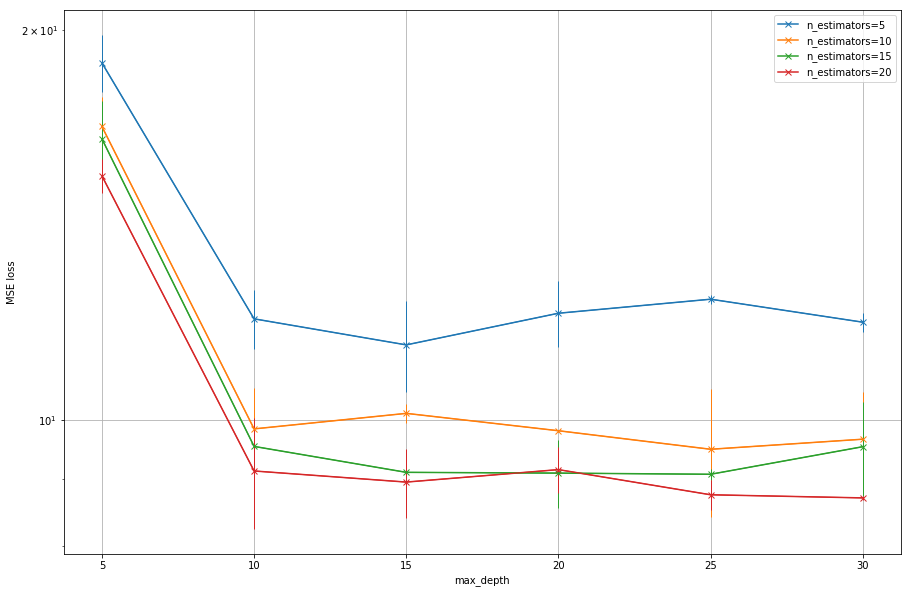

Min loss:
{'history_steps': 1, 'model': {'n_estimators': 20, 'n_jobs': 7, 'max_depth': 30}, 'l2_std': 0.03114723817761611, 'l2_mean': 8.708364807092877}

{'history_steps': 1, 'model': {'n_estimators': 20, 'n_jobs': 7, 'max_depth': 30}, 'l2_std': 0.03114723817761611, 'l2_mean': 8.708364807092877}


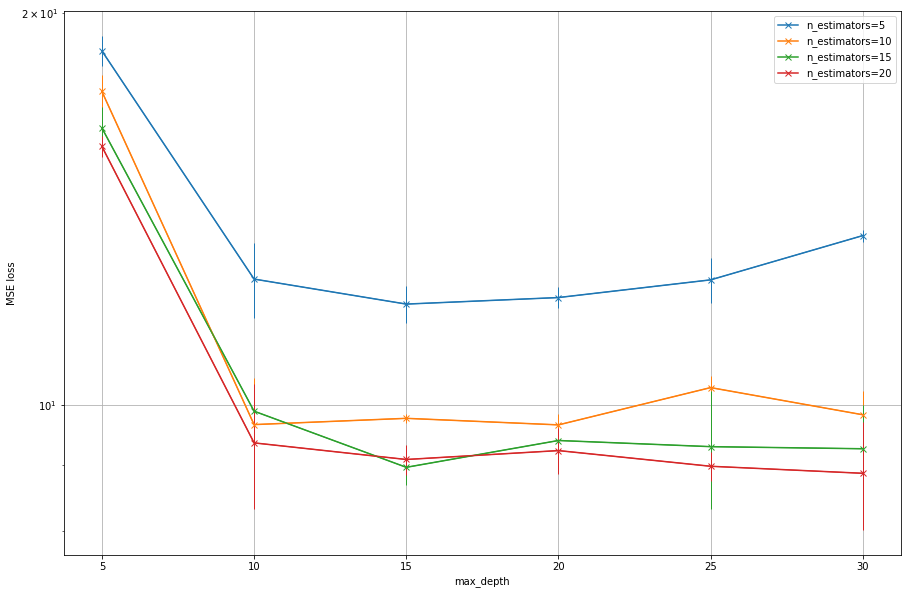

Min loss:
{'history_steps': 3, 'model': {'n_estimators': 20, 'n_jobs': 7, 'max_depth': 30}, 'l2_std': 0.8480707573843027, 'l2_mean': 8.86652086521429}

{'history_steps': 3, 'model': {'n_estimators': 10, 'n_jobs': 7, 'max_depth': 10}, 'l2_std': 0.8306530297208639, 'l2_mean': 9.663489363025445}
{'history_steps': 3, 'model': {'n_estimators': 10, 'n_jobs': 7, 'max_depth': 20}, 'l2_std': 0.18325827657215576, 'l2_mean': 9.658629779033696}
{'history_steps': 3, 'model': {'n_estimators': 15, 'n_jobs': 7, 'max_depth': 15}, 'l2_std': 0.2759356009069487, 'l2_mean': 8.960825616381545}
{'history_steps': 3, 'model': {'n_estimators': 15, 'n_jobs': 7, 'max_depth': 20}, 'l2_std': 0.040842343080088384, 'l2_mean': 9.395613947842715}
{'history_steps': 3, 'model': {'n_estimators': 15, 'n_jobs': 7, 'max_depth': 25}, 'l2_std': 0.9665809385038546, 'l2_mean': 9.294039622478302}
{'history_steps': 3, 'model': {'n_estimators': 15, 'n_jobs': 7, 'max_depth': 30}, 'l2_std': 0.7395669882817186, 'l2_mean': 9.2597110594

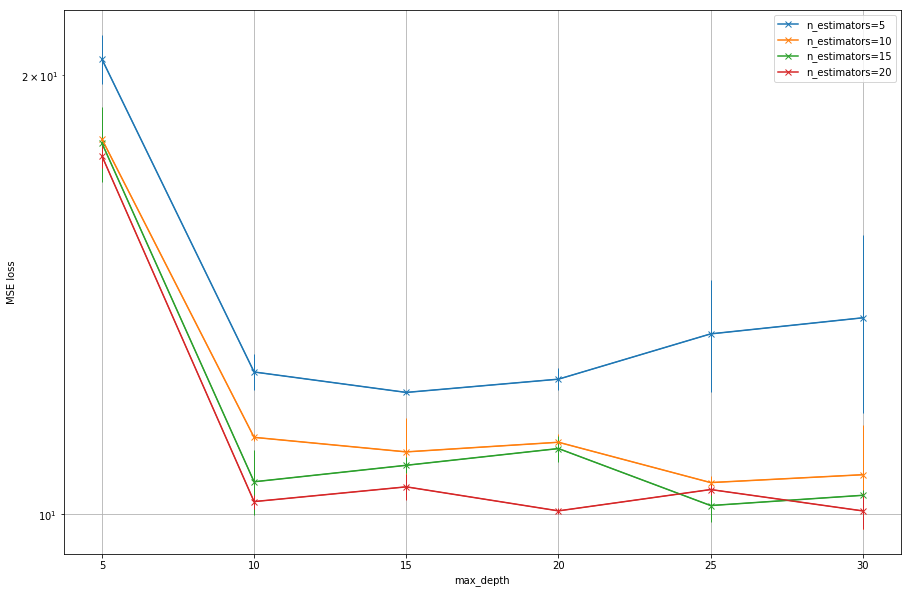

Min loss:
{'history_steps': 5, 'model': {'n_estimators': 20, 'n_jobs': 7, 'max_depth': 30}, 'l2_std': 0.2859282780748007, 'l2_mean': 10.054328169820195}

{'history_steps': 5, 'model': {'n_estimators': 15, 'n_jobs': 7, 'max_depth': 25}, 'l2_std': 0.26699137687669783, 'l2_mean': 10.139795308363134}
{'history_steps': 5, 'model': {'n_estimators': 15, 'n_jobs': 7, 'max_depth': 30}, 'l2_std': 0.08713889835054012, 'l2_mean': 10.305424367865527}
{'history_steps': 5, 'model': {'n_estimators': 20, 'n_jobs': 7, 'max_depth': 10}, 'l2_std': 0.1138521092605087, 'l2_mean': 10.203356598768337}
{'history_steps': 5, 'model': {'n_estimators': 20, 'n_jobs': 7, 'max_depth': 20}, 'l2_std': 0.048542679033413805, 'l2_mean': 10.055055212638724}
{'history_steps': 5, 'model': {'n_estimators': 20, 'n_jobs': 7, 'max_depth': 30}, 'l2_std': 0.2859282780748007, 'l2_mean': 10.054328169820195}


In [144]:
def plot_params(params):    
    fig, axes = plt.subplots(1, 1, figsize=(15, 10))
    
    for i, n_estimators in enumerate(np.unique([p['model']['n_estimators'] for p in params])):
        ax = axes

        pars = [p for p in params if p['model']['n_estimators'] == n_estimators]
        x = [p['model']['max_depth'] for p in pars]
        y = [p['l2_mean'] for p in pars]
        yerr = [p['l2_std'] for p in pars]

        ax.set_yscale("log", nonposy='clip')

        p = ax.plot(x, y, 'x-', label="n_estimators=%d" % (n_estimators))
        ax.errorbar(x, y ,yerr=yerr, linewidth=1, color=p[0].get_color())

    plt.xlabel('max_depth')
    plt.ylabel('MSE loss')
    plt.grid()
    plt.legend()
    plt.show()


    l2_mean = [p['l2_mean'] for p in params]
    l2_std = [p['l2_std'] for p in params]
    min_idx = np.argmin(l2_mean)

    print 'Min loss:'
    print params[min_idx]
    print ''

    param_stdrule = [p for p in params if p['l2_mean'] < params[min_idx]['l2_mean'] + params[min_idx]['l2_std']]
    for p in param_stdrule:
        print p

for history_steps in np.unique([p['history_steps'] for p in params]):
    plot_params([p for p in params if p['history_steps'] == history_steps])